#Iniciando em PySpark

Este documento descreve basicamente como utilizar Apache Spark, Hadoop e PySpark.
Ele também demonstra a utilização de algoritimos de clusterização (KMeans) e plotar gráficos de dispersão com o módulo Matplotlib.

##Dados

Utilizamos como fonte de dados o CSV do Titanic Challenge do Kaggle.

Fizemos uma pequena modificação alterando a vírgula (,) como separador para ponto-e-virgula (;) pois estava gerando um problema ao fazer o split(',') pois os passageiros tem vírgula em seus nomes (Sobrenome, Primeiro Nome)

##Ambiente

O ambiente em que rodamos nossos scripts foi um notebook rodando Ubuntu 14.04 .

* Hadoop: Instalação básica em modo Single Node conforme indicado no site oficial
* Spark: Instalação básica conforme descrito no site oficial
* Python: versão 2.7.6
* IPython: versão 3.2.1 com profile customizado para integrar com PySpark

##Começando a brincadeira

Carregando módulos

In [2]:
from pyspark import SparkContext
from pyspark.sql import Row
from pyspark.mllib.clustering import KMeans, KMeansModel
from sklearn import datasets
from numpy import array, sqrt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Nas linhas abaixo nós inicializamos o SparkContext e em seguida carregamos o arquivo do Hadoop HDFS, e já "splitamos" as linhas na função "map"

In [3]:
sc = SparkContext('local', 'master')
train = sc.textFile('hdfs://localhost/train.csv').map(lambda x: x.split(';'))

Nosso arquivo vem com a primeira linha sendo o cabeçalho, portando, aplicamos a função "filter" para remover esta linha. Esta não é a forma mais elegante, podemos melhorar (sugestões?!).

In [4]:
header = train.first()
train_filter = train.filter(lambda item: item != header)

Em seguida, nós criamos um novo dataset para facilitar o acesso aos atributos da nossa lista. Desta forma, ao invés de acessarmos através de, por exemplo, item[6] nós podemos acessar item.Age.

In [5]:
train_norm = train_filter.map(lambda item: Row(
PassengerId=item[0],Survived=item[1],Pclass=item[2],Name=item[3],Sex=item[4],
Age=item[5],SibSp=item[6],Parch=item[7],Ticket=item[8],Fare=item[9],Cabin=item[10],Embarked=item[11]))

Iremos trabalhar com o dado "Age" e em nossos dados, alguns passageiros não possuem o dado. Para resolver isso, iremos calcular a média de idade dos passageiros que tem o dado "Age" e preencher os registros que não tem o dado. Para tal, faremos outro "filter", em seguida um "map" retornando apenas a idade e em seguida "reduce" somando os valores.

In [6]:
_with_age = train_norm.filter(lambda item: item.Age != '')
sum_age = _with_age.map(lambda item: (float(item.Age), 1)).fold((0, 0), (lambda x,y: (x[0]+y[0],x[1]+y[1])))
avg_age = int(sum_age[0] / sum_age[1])

print sum_age
print "Idade média dos passageiros: %s" % avg_age

(21205.17, 714)
Idade média dos passageiros: 29


Agora que temos a idade média dos passageiros com idade, vamos criar um novo dataset com os valores corrigidos, depois juntar (join) tudo e ter um dataset com todos registros.

In [218]:
_no_age = train_norm.filter(lambda item: item.Age == '')
_no_age_fix = _no_age.map(lambda item: Row(PassengerId=item[0],Survived=item[1],Pclass=item[2],
                                    Name=item[3],Sex=item[4],SibSp=item[6],Parch=item[7],
                                    Ticket=item[8],Fare=item[9],Cabin=item[10],Embarked=item[11],
                                    Age=avg_age))
train_clean = _with_age.union(_no_age_fix)

Apenas para fins apenas didáticos, iremos plotar Idade x Tarifa e iremos encontrar o agrumamento com o menor erro e plotar novamente Idade x Tarifa mas desta vez colorindo os itens de acordo com seu agrupamento.

Portanto, iniciamos com um gráfico de dispersão Idade x Tarifa.

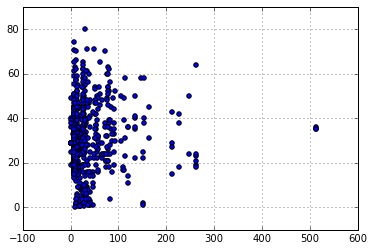

In [225]:
y_ages = train_clean.map(lambda item: float(item.Age))
x_fares = train_clean.map(lambda item: float(item.Fare))

plt.scatter(x_fares.collect(), y_ages.collect())
plt.grid()

Agora criaremos um dataset com os dados que iremos testar para montar nosso cluster.

In [228]:
train_cluster_data = train_clean.map(lambda item: array([float(item.Age), float(item.Fare)]))
train_cluster_data.take(3)

[array([ 22.  ,   7.25]),
 array([ 38.    ,  71.2833]),
 array([ 26.   ,   7.925])]

A seguir, iremos rodar o algoritimo KMeans para encontrar o K com menor erro. Para isso, iremos interar K's de 2 até 16, plotar um gráfico com os erros.

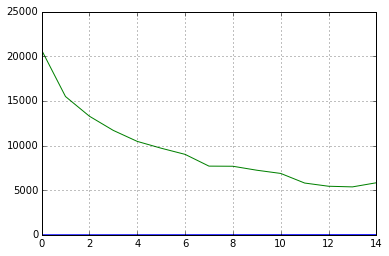

In [230]:
clustering_errors=[]
for i in range(2,10):
    clusters = KMeans.train(train_cluster_data, i, maxIterations=10, runs=10, initializationMode="random")
    def error(point):
        center = clusters.centers[clusters.predict(point)]
        return sqrt(sum([x**2 for x in (point - center)]))
    WSSSE = train_cluster_data.map(lambda item: error(item)).reduce(lambda x, y: x+y)
    clustering_errors.append(array([i, WSSSE]))
    
plt.plot(clustering_errors)
plt.grid()

Em seguida, uma tabela con os dados:

In [232]:
clusters_errors_set = pd.DataFrame(clustering_errors)
clusters_errors_set

,0,1
0,2,20700.143942
1,3,15489.211938
2,4,13282.573830
3,5,11691.749660
4,6,10463.039961
5,7,9699.404811
6,8,9010.309671
7,9,7692.019132
8,10,7677.716188
9,11,7233.120745


Verificamos que o K com menor erro é um cluster com 15 grupos. Então, montarmos nosso cluster com 15 grupos.

In [236]:
cluster = KMeans.train(train_cluster_data, 15, maxIterations=10, runs=10, initializationMode="random")

Agora é só arrumar a casa, plotar os dados e sair pro abraço!

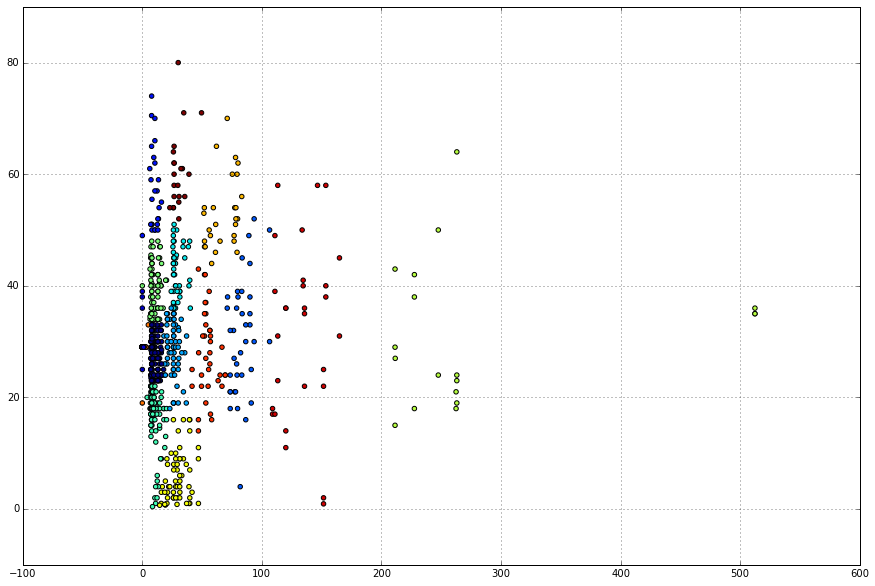

In [238]:
x = train_clean.map(lambda item: item.Fare).collect()
y = train_clean.map(lambda item: item.Age).collect()
c = train_clean.map(lambda item: cluster.predict([item.Age, item.Fare])).collect()

plt.figure(figsize=(15,10))
plt.scatter(x, y, c=c)
plt.grid()